In [18]:
from ogs6py import ogs
import os
import ogs6py
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time
import math
from types import MethodType

pi = math.pi
%matplotlib inline
plt.rcParams['text.usetex'] = True

# Great Cell - 2D

<!-- ![Benchmarking idea](./figures/greatcell_benchmarking.png "Benchmarking idea.") -->

<img src="./figures/greatcell_benchmarking.png#one-half" alt="Benchmarking idea." style="width:700px;">

### Path

In [19]:
#file's name
prj_path='./'
prj_name = "great_cell_2d_PressurizedFracture.prj"
ogs_path = "~/dynamicPhasefield/build-THMPF-updateTao-dynamic/bin/ogs" #

## Definition of functions

### Set Young's modulus and Poisson's ratio for the main sample and rubber sheath

<img src="./figures/YoungModulus_2D.png#one-half" alt="Young's modulus and Poisson's ratio for the main sample and rubber sheath" style="width:300px;">

In [20]:
def set_E_nu(in_m, out_m,young_sample,nu_sample,young_sheath, nu_sheath):
    m = pv.read(f'{prj_path}/{in_m}')
    n_cells = m.n_cells
    
    young = np.zeros(n_cells)
    nu = np.zeros(n_cells)

    for i in range(n_cells):
        cell = m.GetCell(i)
        x_min,x_max,y_min,y_max,z_min,z_max = cell.GetBounds()
        
        x = (x_min+x_max)/2
        y = (y_min+y_max)/2
        if (x**2 + y**2) > 0.097**2:
            young[i] = young_sheath
            nu[i] = nu_sheath
        else:
            young[i] = young_sample
            nu[i] = nu_sample

    m.cell_data['E'] = young
    m.cell_data['nu'] = nu

    m.save(f'{prj_path}/{out_m}',False)

### Set initial phase field (fracture) and pressure

For the fractured cases, we consider two scenarios: 2-wing fracture and one-wing fracture. You can use the following functions to set the initial phase field:

1. Two-wing fracture: $[-0.065, 0.065] \times \{0\}$
2. One-wing fracture: $[0, 0.065] \times \{0\}$


Note: We do not call this function for mechanical deformation in sound samples, where there is an absence of fracture.

In [21]:
initial_pressure = 2.e6

In [22]:
def set_crack(in_m,out_m, full, initial_pressure):
    m = pv.read(f'{prj_path}/{in_m}')
    n_points = m.number_of_points
    pt_coords = m.points

    phasefield = np.zeros(n_points)
    pressure = np.zeros(n_points)
    
    r1 = 0.065
    h1 = 0.002

    for point_id in range(0, n_points):
        x=pt_coords[point_id, 0]
        y=pt_coords[point_id, 1]
        
        #if distance <= radius :
        if full == True:
            if abs(x) < r1 and abs(y) < h1 :
                phasefield[point_id] =  0
                pressure[point_id] =  initial_pressure
            else:
                phasefield[point_id] = 1
                pressure[point_id] =  0.
        else:
            if 0 < x < r1 and abs(y) < h1 :
                phasefield[point_id] =  0
                pressure[point_id] =  initial_pressure
            else:
                phasefield[point_id] = 1
                pressure[point_id] =  0.

    m.point_data['pf-ic'] = phasefield
    m.point_data['p-ic'] = pressure

    m.save(f'{prj_path}/{out_m}',False)

<div style="display: flex;">
  <img src="./figures/PF_1wingFracture_2D.png#one-half" alt="Initial phase field profile for one wing fracture" style="width:300px;">
  <img src="./figures/pressure_1wingFracture_2D.png#one-half" alt="Initial pressure profile for one wing fracture" style="width:300px;">
</div>



<div style="display: flex;">
  <img src="./figures/PF_2wingsFracture_2D.png#one-half" alt="Initial phase field profile for two wings fracture" style="width:300px;">
  <img src="./figures/pressure_2wingsFracture_2D.png#one-half" alt="Initial pressure profile for two wings fracture" style="width:300px;">
</div>


### Set the loading conditions for BAGs (PEEs) and STRIP (DSSs)

Assign loading Conditions for BAG segments and apply on STRIP segments loading average of surrounding BAG segments.
<!-- ![Schematic view of Great Cell BC](./figures/greatcell_loading_schematic_xy.png#one-half "Schematic view of Great Cell BC.") -->

<img src="./figures/greatcell_loading_schematic_xy.png#one-half" alt="Schematic view of Great Cell BC." style="width:400px;">


In [23]:
# define method to be assigned to model, to replace a specific curve, given by name 
# (analogue to replace_parameter method)
def replace_curve(self, name=None, value=None, coords=None, parametertype=None, valuetag="values", coordstag="coords"):
    root = self._get_root()
    parameterpath = "./curves/curve"
    parameterpointer = self._get_parameter_pointer(root, name, parameterpath)
    self._set_type_value(parameterpointer, value, parametertype, valuetag=valuetag)
    self._set_type_value(parameterpointer, coords, parametertype, valuetag=coordstag)

# define method to be assigned to model, to calculate loads for all STRIP BC from BAG BC and assign them, 
# when not done by apply_F_to_all
def set_strips(self, valuetag="values", coordstag="coords"):
    root = self._get_root()
    parameterpath = "./curves/curve"
    
    for i in range(1,17):
        alpha_a = (2*np.pi/16) * (i-1)
        alpha_b = (2*np.pi/16) * (i%16)
        parameterpointer_a = self._get_parameter_pointer(root, "BAG_"+str(i)+"_SURFACE_FX_CURVE", parameterpath)
        parameterpointer_b = self._get_parameter_pointer(root, "BAG_"+str(i%16+1)+"_SURFACE_FX_CURVE", parameterpath)
        for paramproperty in parameterpointer_a:
            if paramproperty.tag == valuetag:
                F_X_a = [float(x) for x in paramproperty.text.split(' ')]
            elif paramproperty.tag == coordstag:
                coords = paramproperty.text
        for paramproperty in parameterpointer_b:
            if paramproperty.tag == valuetag:
                F_X_b = [float(x) for x in paramproperty.text.split(' ')]
        F_a = [-x/np.cos(alpha_a) for x in F_X_a]
        F_b = [-x/np.cos(alpha_a) for x in F_X_b]
        F = [0.5*(F_a[i]+F_b[i]) for i in range(len(F_a))]
        F_X = []
        F_Y = []
        for F_i in F:
            a, b = decompose_F(F_i,i+0.5)
            F_X.append(a)
            F_Y.append(b)
        values_F_X = ' '.join(map(str, F_X))
        values_F_Y = ' '.join(map(str, F_Y))
        self.replace_curve(name="STRIP_"+str(i)+"_SURFACE_FX_CURVE",value=values_F_X, coords=coords)
        self.replace_curve(name="STRIP_"+str(i)+"_SURFACE_FY_CURVE",value=values_F_Y, coords=coords)


In [24]:
def decompose_F(F,n):
    # decompose normal Force into x and y depending on number of Boundary
    alpha = (2*np.pi/16) * (n-1)
    F_X = - np.cos(alpha) * F
    F_Y = np.sin(alpha) * F
    return F_X, F_Y

def apply_F_to_BAG(model,F,n,coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    F_X, F_Y = decompose_F(F,n)
    F_X = [x*F_X for x in value_mult]
    F_Y = [x*F_Y for x in value_mult]
    values_F_X = ' '.join(map(str, F_X))
    values_F_Y = ' '.join(map(str, F_Y))
    model.replace_curve(name="BAG_"+str(n)+"_SURFACE_FX_CURVE",value=values_F_X, coords=coords)
    model.replace_curve(name="BAG_"+str(n)+"_SURFACE_FY_CURVE",value=values_F_Y, coords=coords)
    
def apply_F_to_STRIP(model,F_a, F_b,n,coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    F = 0.5*(F_a+F_b)
    F_X, F_Y = decompose_F(F,n+0.5)
    F_X = [x*F_X for x in value_mult]
    F_Y = [x*F_Y for x in value_mult]
    values_F_X = ' '.join(map(str, F_X))
    values_F_Y = ' '.join(map(str, F_Y))
    model.replace_curve(name="STRIP_"+str(n)+"_SURFACE_FX_CURVE",value=values_F_X, coords=coords)
    model.replace_curve(name="STRIP_"+str(n)+"_SURFACE_FY_CURVE",value=values_F_Y, coords=coords)
    
def apply_F_to_all(model,F_values,t_coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    # apply given F_values as BC on BAG and mean values on STRIP in between, 
    # with given time coordinates t_coords in given loading steps value_mult
    # F_values for example: [10e6,0,0,0,5e6,0,0,0,10e6,0,0,0,5e6,0,0,0]
    for i in range(1,17):
        apply_F_to_BAG(model,F_values[i-1],i,t_coords,value_mult)
        apply_F_to_STRIP(model,F_values[i-1], F_values[i%16],i,t_coords,value_mult)



### Different loading conditions 


1. Constant values for two pairs of PEEs  (e.g., for 0 degrees: PEEs 1, 1a, 5, and 5a are all set to 8 MPa, angles are 0, 22.5, 45, 67.5 degrees).

| Angle ($^\circ$)  | Loading Conditions        |
| ----------------- | ------------------------- |
| 0                 | PEEs 1 & 1a: 8 MPa        |
|                   | PEEs 5 & 5a: 8 MPa        |
| 22.5              | PEEs 8 & 8a: 8 MPa        |
|                   | PEEs 4 & 4a: 8 MPa        |
| 45                | PEEs 7 & 7a: 8 MPa        |
|                   | PEEs 3 & 3a: 8 MPa        |
| 67.5              | PEEs 6 & 6a: 8 MPa        |
|                   | PEEs 2 & 2a: 8 MPa        |
| DSSs: zero                               |



2. M1 loading includes:
   - M1_triaxial
   - M1_axisymmetric
   
|                   | **True Triaxial**       | **Axisymmetric**       |
|-------------------|-------------------------|------------------------|
|                   | PEEs 1 & 1a: 7.73 MPa    | PEEs 1 & 1a: 7.71 MPa   |
|                   | PEEs 2 & 2a: 5.70 MPa    | PEEs 2 & 2a: 7.70 MPa   |
|                   | PEEs 3 & 3a: 4.39 MPa    | PEEs 3 & 3a: 8.30 MPa   |
|                   | PEEs 4 & 4a: 2.40 MPa    | PEEs 4 & 4a: 7.80 MPa   |
|                   | PEEs 5 & 5a: 2.30 MPa    | PEEs 5 & 5a: 7.74 MPa   |
|                   | PEEs 6 & 6a: 4.00 MPa    | PEEs 6 & 6a: 7.70 MPa   |
|                   | PEEs 7 & 5a: 6.40 MPa    | PEEs 7 & 7a: 8.30 MPa   |
|                   | PEEs 8 & 8a: 7.70 MPa    | PEEs 8 & 8a: 7.72 MPa   |
|                   | DSSs: average of loads of adjacent PEEs | DSSs: average of loads of adjacent PEEs |



Hint: You can set the load at the top surface for 3D cases using `apply_F_to_TOP(model11__, -6.e6)`. 

In [25]:
def apply_xy_load(n_angle):
    ##################
    # n angel 0,1,2,3 for 0, 22.5, 45, 67.5 °
    ##################
    
    model1 = ogs.OGS(INPUT_FILE=prj_path+prj_name, PROJECT_FILE=prj_path+prj_name, MKL=True)
    model1.replace_curve = MethodType(replace_curve, model1)
    
    #set every BC zero
    apply_F_to_all(model1,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        
    for i in [1,5,9,13]:
        apply_F_to_BAG(model1,8e6,n_angle+i)

    model1.write_input()
    
def apply_M1_load(case):
    if case == 'M1_triaxial':
        model11_ = ogs.OGS(INPUT_FILE=prj_path+prj_name, PROJECT_FILE=prj_path+prj_name, MKL=True)
        model11_.replace_curve = MethodType(replace_curve, model11_)
        apply_F_to_all(model11_,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        apply_F_to_all(model11_,[7.73e6,5.7e6,4.39e6,2.4e6,2.3e6,4e6,6.4e6,7.7e6,7.73e6,5.7e6,4.39e6,2.4e6,2.3e6,4e6,6.4e6,7.7e6])
        model11_.write_input()
    elif case == 'M1_axisymmetric':
        model11__ = ogs.OGS(INPUT_FILE=prj_path+prj_name, PROJECT_FILE=prj_path+prj_name, MKL=True)
        model11__.replace_curve = MethodType(replace_curve, model11__)
        apply_F_to_all(model11__,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        apply_F_to_all(model11__,[7.71e6,7.7e6,8.3e6,7.8e6,7.74e6,7.7e6,8.3e6,7.72e6,7.71e6,7.7e6,8.3e6,7.8e6,7.74e6,7.7e6,8.3e6,7.72e6])
        model11__.write_input()
    else:
        print(f'Oops somethings wrong in the code. Wrong input "{case}"" should not have made it this far...')
        
    
    

### Run the simulations

We have several options to choose from: `M1_triaxial`, `M1_axisymmetric`, `M3a`, `M3b`, `HM3a`, `HM3b`.

1. Material properties of the sample and rubber sheath are introduced here.

2. In `M1_triaxial` and `M1_axisymmetric`, we only run simulations for mechanical deformation in the absence of fracture (phase field is set to 1 for the entire domain).

3. In all `M3a`, `HM3a`, `M3b`, `HM3b` cases, fractures exist (phase field is active).

4. In cases `HM3a` and `HM3b`, the pressure is set by `pressure_ic=2.0 MPa` (to model a pressurized fracture), meaning the pressure is applied only to the faces of the crack.


In [26]:
def run_benchmark(case):
    #case is one of [M1_triaxial, M1_axisymmetric, M3a, M3b, HM3a, HM3b]
    in_m = "2d_mesh.vtu"
    young_sample = 3.85e9
    nu_sample = 0.4
    young_sheath = 0.1e9
#     young_sheath = 3.85e9
    nu_sheath = 0.4
    set_E_nu(in_m,in_m,young_sample,nu_sample,young_sheath, nu_sheath)

    
    # introduce crack
    if case in ['M1_triaxial','M1_axisymmetric']:
        m = pv.read(f'{prj_path}/{in_m}')
        n_points = m.number_of_points
        pt_coords = m.points
        phasefield = np.ones(n_points)
        m.point_data['pf-ic'] = phasefield
        m.save(f'{prj_path}/{in_m}',False)
        
        out_dir = f"results_{case}"
        if not os.path.exists(f"./{out_dir}"):
            os.makedirs(f"./{out_dir}")  
        
        apply_M1_load(case)
        #run ogs
        t0 = time.time()
        print(">>> OGS started execution ... <<<")
        print(prj_name)
        !{ogs_path} {prj_path+prj_name} -o  {out_dir} > log #results_case2 > log #results_M_XYloading
        tf = time.time()
        print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")
        
    
    elif case in ['M3a','HM3a','M3b','HM3b']:
        if case in ['M3a','HM3a']:
            set_crack(in_m,in_m, True, initial_pressure)
        else:
            set_crack(in_m,in_m, False, initial_pressure)
            
        model = ogs.OGS(INPUT_FILE=f"{prj_path+prj_name}", PROJECT_FILE=f"{prj_path+prj_name}", MKL=True)
        if case in ['M3a','M3b']:
            model.replace_parameter_value(name="pressure_ic", value=0)
        else:
            model.replace_parameter_value(name="pressure_ic", value=initial_pressure)  
        model.write_input()
        for i in [0,1,2,3]:
            apply_xy_load(i)

            out_dir = f"results_{case}_angle{i*22.5}"
            if not os.path.exists(f"./{out_dir}"):
                os.makedirs(f"./{out_dir}")  

            #run ogs
            t0 = time.time()
            print(">>> OGS started execution ... <<<")
            print(prj_name)
            !{ogs_path} {prj_path+prj_name} -o  {out_dir} > log #results_case2 > log #results_M_XYloading
            tf = time.time()
            print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")
            
    else:
        print(f'{case} not a valid case. Chose one of ["M1_triaxial", "M1_axisymmetric", "M3a", "M3b", "HM3a", "HM3b"]')
        
    
        
    

# Post-processing Functions

The volumetric strain is extracted at locations where `abs(x[0]**2 + x[1]**2 - 0.065**2) < 1e-6`. This means that data is extracted at a radial distance of `0.065`.

Hint: The plots are based on extracting data from the last time step vtu file. In case you need to extract data from another timestep output, you can change the file name to `GreatCell_2D_ts_4_t_4.000000.vtu`.

In [27]:
def get_vol_strain(out):
    out_dir=out
    mesh = pv.read(f"{out_dir}/GreatCell_2D_ts_4_t_4.000000.vtu")
    phase_field = np.ones((len(mesh.points),1))
    eps=mesh.point_data["epsilon"]
    disp=mesh.point_data["displacement"]
    eps_v=[]
    eps_r=[]
    phi=[]
    u_r=[]
    for node_id, x in enumerate(mesh.points):
        if  abs(x[0]**2+x[1]**2-0.065**2)<1e-5:

            eps_vol=abs(eps[node_id][0]+eps[node_id][1])#+eps[node_id][2])
            eps_v.append(eps_vol)
            theta = math.atan2(x[1], x[0])
            theta_p=theta
            if theta_p < 0:
                theta_p += 2*math.pi
            phi.append(theta_p)

    sort_idx = np.argsort(phi)
    phi_sorted = [phi[i] for i in sort_idx]
    eps_v_sorted = [eps_v[i] for i in  sort_idx]
   
    return np.array(phi_sorted), np.array(eps_v_sorted)


In [28]:
def postproc_benchmark(case):
    colors =  [
    "#FFB733",  # Lighter Shade
    "#FFA800",  # More Saturated Shade
    "#D97F00",  # Less Saturated Shade
    "#FF8C00",  # Another Shade
    "#C28300",  # Darker Shade
]
    markers = ['o', 's', 'd', '*', 'o','s']
    
    if case in ['M1_triaxial','M1_axisymmetric']:        
        out_dir = f"results_{case}"
        angles, strain = get_vol_strain(out_dir)

        fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
        ax = fig.add_subplot(1, 1, 1)
        
        plt.plot(angles*180/math.pi,strain*1e6,  marker=markers[0],fillstyle='none', color=colors[0])
        
        
        
        plt.grid(linestyle='dashed') 
        major_ticks = np.arange(0, 370, 45)
        ax.set_xticks(major_ticks)
        ax.grid(which='both')
        ax.grid(which='major', alpha=0.5)
        ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
        ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis

        plt.ylim([0,1500])
        plt.xlim([0,360])
        plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
        plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
        #legend_ = ax.legend(loc='lower right')
        plt.title(f'{case}',fontsize =18)
        plt.show()

        
    elif case in ['M3a','HM3a','M3b','HM3b']:
        strain_list = []
        for i in [0,1,2,3]:
            out_dir = f"results_{case}_angle{i*22.5}"
            angles, strain = get_vol_strain(out_dir)
            strain_list.append(strain)
    
        strain_array = np.array(strain_list)
        
        fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
        ax = fig.add_subplot(1, 1, 1)
        for i in [0,1,2,3]:
            plt.plot(angles*180/math.pi,strain_array[i]*1e6,  marker=markers[i],fillstyle='none', color=colors[i], label=f'{i*22.5}°')


        plt.grid(linestyle='dashed') 
        major_ticks = np.arange(0, 370, 45)
        ax.set_xticks(major_ticks)
        ax.grid(which='both')
        ax.grid(which='major', alpha=0.5)
        ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
        ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis

        plt.ylim([0,1500])
        plt.xlim([0,360])
        plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
        plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
        legend_ = ax.legend(loc='lower right')
        plt.title(f'{case}',fontsize =18)
        plt.show()


# Run the simulations and Post-processing


# Mechanical

>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  2.42  s.


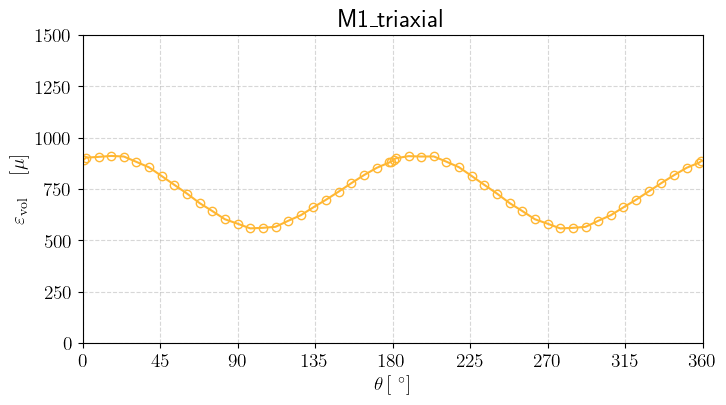

In [29]:
run_benchmark('M1_triaxial')
postproc_benchmark('M1_triaxial')

>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  2.37  s.


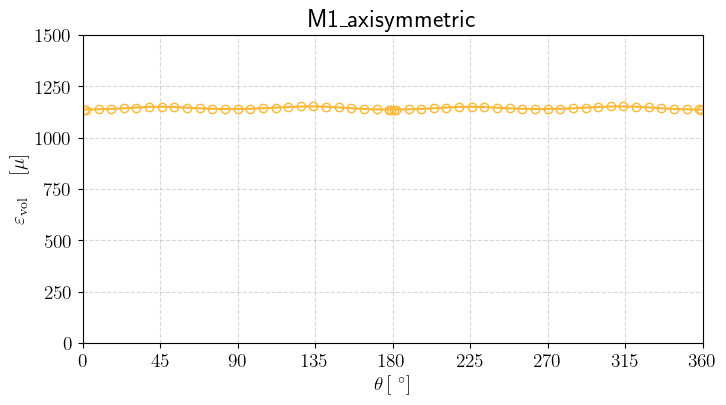

In [30]:
run_benchmark('M1_axisymmetric')
postproc_benchmark('M1_axisymmetric')

# Fractured samples

>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.67  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.82  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.35  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.75  s.


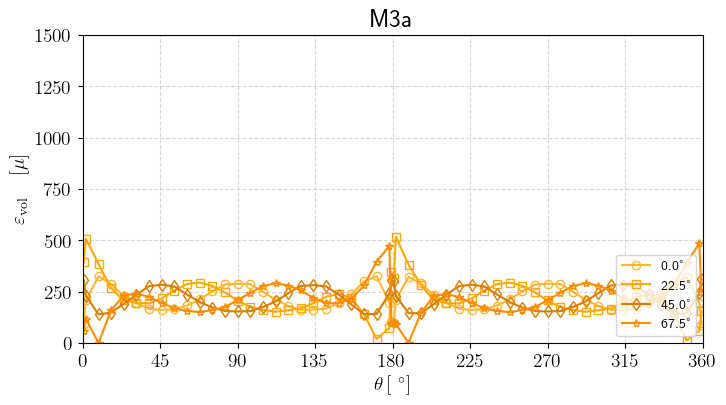

In [31]:
run_benchmark('M3a')
postproc_benchmark('M3a')

>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.49  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.45  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.23  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.49  s.


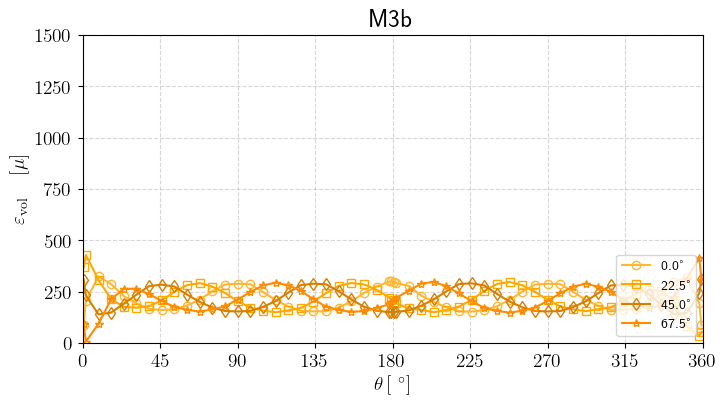

In [32]:
run_benchmark('M3b')
postproc_benchmark('M3b')

# Pressurized fractured samples

>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  6.77  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  4.3  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  3.77  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  4.18  s.


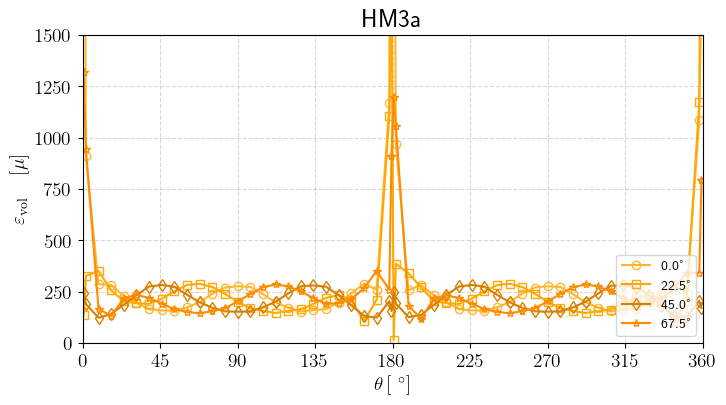

In [33]:
run_benchmark('HM3a')
postproc_benchmark('HM3a')

>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  4.29  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  4.06  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  4.01  s.
>>> OGS started execution ... <<<
great_cell_2d_PressurizedFracture.prj
>>> OGS terminated execution  <<< Elapsed time:  4.24  s.


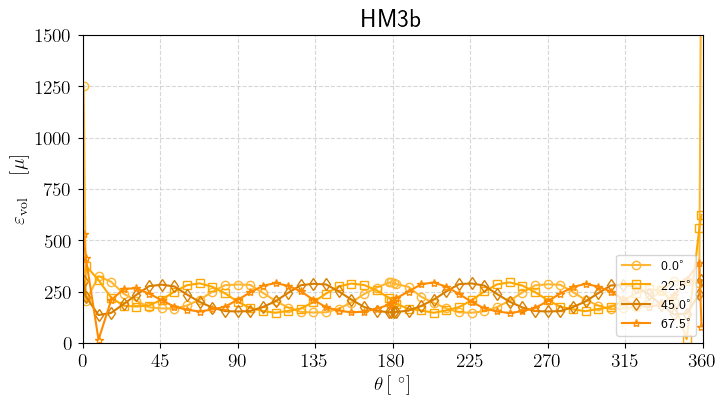

In [34]:
run_benchmark('HM3b')
postproc_benchmark('HM3b')